DESCRIPTION

Identify the level of income qualification needed for the families in Latin America.

Problem Statement Scenario:
Many social programs have a hard time ensuring that the right people are given enough aid. It’s tricky when a program focuses on the poorest segment of the population. This segment of the population can’t provide the necessary income and expense records to prove that they qualify.

In Latin America, a popular method called Proxy Means Test (PMT) uses an algorithm to verify income qualification. With PMT, agencies use a model that considers a family’s observable household attributes like the material of their walls and ceiling or the assets found in their homes to
classify them and predict their level of need.

While this is an improvement, accuracy remains a problem as the region’s population grows and poverty declines.

The Inter-American Development Bank (IDB)believes that new methods beyond traditional econometrics, based on a dataset of Costa Rican household characteristics, might help improve PMT’s performance.
Following actions should be performed:

            1. Identify the output variable.
            2. Understand the type of data.
            3. Check if there are any biases in your dataset.
            4. Check whether all members of the house have the same poverty level.
            5. Check if there is a house without a family head.
            6. Set poverty level of the members and the head of the house within a family.
            7. Count how many null values are existing in columns.
            8. Remove null value rows of the target variable.
            9. Predict the accuracy using random forest classifier.
            10 Check the accuracy using random forest with cross validation.

In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics as metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import seaborn as sns; sns.set()
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
import pickle

In [2]:
train = pd.read_csv(r"C:\Users\adity\Documents\Machine-Learning--Projects-master\Projects\Projects for Submission\Project 2 - Income Qualification\Dataset for the project\train.csv")
test = pd.read_csv(r"C:\Users\adity\Documents\Machine-Learning--Projects-master\Projects\Projects for Submission\Project 2 - Income Qualification\Dataset for the project\test.csv")

In [3]:
test['Target']=100

In [4]:
train.head(5)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [5]:
test.head(5)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,0,16,9,0,1,2.25,0.25,272.25,16,100
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,256,1681,9,0,1,2.25,0.25,272.25,1681,100
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,289,1681,9,0,1,2.25,0.25,272.25,1681,100
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,256,3481,1,256,0,1.00,0.00,256.00,3481,100
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,121,324,1,0,1,0.25,64.00,NaN,324,100


# Identify the Output Variable

In [6]:
train.Target.unique()

array([4, 2, 3, 1], dtype=int64)

As we see, Target column is the output variable, which denotes the poverty level of the Person.

In [7]:
#Find columns in train dataset which is not there in test dataset.
for column in train.columns:
    if column not in test.columns:
        print(column+" not present in test data set")

In [8]:
print(train.shape,test.shape)

(9557, 143) (23856, 143)


In [9]:
#Concatenate train and test data
master = pd.concat([train,test.reset_index(drop=True)],axis=0)
master.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [10]:
#Check the type of Data
master.dtypes

Id                  object
v2a1               float64
hacdor               int64
rooms                int64
hacapo               int64
                    ...   
SQBovercrowding    float64
SQBdependency      float64
SQBmeaned          float64
agesq                int64
Target               int64
Length: 143, dtype: object

In [11]:
print(master.shape)

(33413, 143)


# Count how many null values are existing in columns.

In [12]:
#Find columns with null values
for col in master.columns:
    if master[col].isna().sum() > 0:
        print("Num of Null values in Column: "+col+" = "+str(master[col].isna().sum()))

Num of Null values in Column: v2a1 = 24263
Num of Null values in Column: v18q1 = 25468
Num of Null values in Column: rez_esc = 27581
Num of Null values in Column: meaneduc = 36
Num of Null values in Column: SQBmeaned = 36


In [13]:
master.v18q1.unique()

array([nan,  1.,  2.,  3.,  4.,  5.,  6.])

In [14]:
master.rez_esc.unique()

array([nan,  1.,  0.,  3.,  2.,  4.,  5., 99.])

In [15]:
master.v2a1.value_counts()

100000.0    581
150000.0    579
200000.0    511
120000.0    379
50000.0     364
           ... 
268000.0      1
56000.0       1
478000.0      1
191000.0      1
234000.0      1
Name: v2a1, Length: 302, dtype: int64

In [16]:
master.v18q1.isnull().sum()

25468

# Impute null values

In [17]:
#replace v18q1 with mode of v18q1 for that idhogar
master.v18q1.fillna(0,inplace=True)
x = master.groupby('idhogar').v18q1.agg(pd.Series.mode).to_frame().reset_index()
for a,b in zip(x.idhogar, x.v18q1):
    master.loc[master['idhogar']==a,'v18q1']=b
master.v18q1.unique()

array([0., 1., 2., 3., 4., 5., 6.])

In [18]:
#drop rez_esc and SQBmeaned
master.drop(["SQBmeaned","rez_esc"],axis=1,inplace=True)

In [19]:
#replace null with mean of v2a1 for that idhogar
master.v2a1.fillna(0.0,inplace=True)
x = master.groupby('idhogar').v2a1.agg("mean").to_frame().reset_index()
for a,b in zip(x.idhogar, x.v2a1):
    master.loc[master['idhogar']==a,'v2a1']=b

In [20]:
#Replace null values in meaneduc with mean of escolari value for the family to which that person belongs
df = master[master.age>=18]
x = df.groupby('idhogar').escolari.agg('mean').to_frame().reset_index()
for a,b in zip(x.idhogar, x.escolari):
    master.loc[master['idhogar']==a,'meaneduc']=b

In [21]:
#Find columns with null values
for col in master.columns:
    if master[col].isna().sum() > 0:
        print("Num of Null values in Column: "+col+" = "+str(master[col].isna().sum()))

Num of Null values in Column: meaneduc = 3


In [22]:
#remaining 3 records dont have anyone who is above 18 years in family, hence replace those with 0
master.meaneduc.fillna(0,inplace=True)

In [23]:
#Find columns with null values
for col in master.columns:
    if master[col].isna().sum() > 0:
        print("Num of Null values in Column: "+col+" = "+str(master[col].isna().sum()))

In [24]:
master.shape

(33413, 141)

In [25]:
master.drop("Id",axis=1,inplace=True)
master.head(5)

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,agesq,Target
0,190000.0,0,3,0,1,1,0,0.0,0,1,...,43,100,1849,1,100,0,1.000000,0.0,1849,4
1,135000.0,0,4,0,1,1,1,1.0,0,1,...,67,144,4489,1,144,0,1.000000,64.0,4489,4
2,0.0,0,8,0,1,1,0,0.0,0,0,...,92,121,8464,1,0,0,0.250000,64.0,8464,4
3,180000.0,0,5,0,1,1,1,1.0,0,2,...,17,81,289,16,121,4,1.777778,1.0,289,4
4,180000.0,0,5,0,1,1,1,1.0,0,2,...,37,121,1369,16,121,4,1.777778,1.0,1369,4


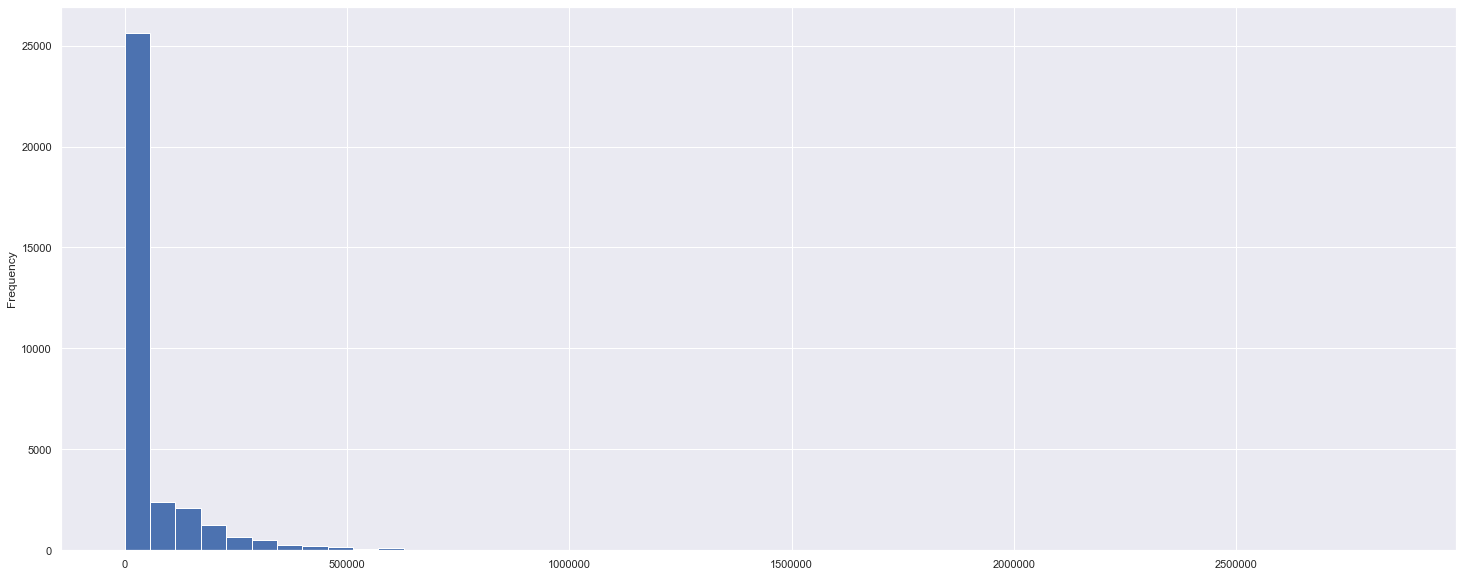

In [26]:
master.v2a1.plot(kind='hist',bins=50,figsize=[25,10])

In [27]:
master.dependency.unique()

array(['no', '8', 'yes', '3', '.5', '.25', '2', '.66666669', '.33333334',
       '1.5', '.40000001', '.75', '1.25', '.2', '2.5', '1.2', '4',
       '1.3333334', '2.25', '.22222222', '5', '.83333331', '.80000001',
       '6', '3.5', '1.6666666', '.2857143', '1.75', '.71428573',
       '.16666667', '.60000002', '.375', '.14285715', '.85714287', '.125',
       '2.3333333', '7', '3.3333333'], dtype=object)

In [28]:
#Replace yes/no with 1/0 in below columns
master.dependency.replace("yes",1.0,inplace=True)
master.dependency.replace("no",0.0,inplace=True)
master.edjefe.replace("yes",1,inplace=True)
master.edjefe.replace("no",0,inplace=True)
master.edjefa.replace("yes",1,inplace=True)
master.edjefa.replace("no",0,inplace=True)

In [29]:
#Convert the data type of below columns
master.dependency = master.dependency.astype('float64')
master.edjefa = master.edjefa.astype('int64')
master.edjefe = master.edjefe.astype('int64')

In [30]:
master.columns

Index(['v2a1', 'hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q', 'v18q1',
       'r4h1', 'r4h2',
       ...
       'age', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe',
       'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'agesq', 'Target'],
      dtype='object', length=140)

# Check whether all members of the house have the same poverty level.

In [31]:
#display households that has diff poverty level
a = master.groupby('idhogar').Target.nunique()>1
diff_target_ids = a[a].index.tolist()
print(diff_target_ids)

['0172ab1d9', '03f4e5f4d', '0511912b6', '078a0b6e2', '09e25d616', '0f3e65c83', '0f9494d3a', '15a891635', '17fb04a62', '18832b840', '26b3a0f41', '288579c97', '28893b5e7', '2c9872b82', '2cb443214', '309fb7246', '30a70901d', '3c6973219', '3c73c107f', '3df651058', '3fe29a56b', '410194c8b', '417865404', '42ec8bef5', '43b9c83e5', '44f219a16', '46af47063', '4b6077882', '4c2dba109', '4dc11e11f', '4e19bd549', '50e064ee8', '513adb616', '54118d5d9', '55a662731', '564eab113', '594d3eb27', '5c3f7725d', '5c6f32bbc', '5e9329fc6', '614b48fb7', '636330516', '654ef7612', '67ad49822', '6833ac5dc', '694a0cbf4', '6a389f3de', '6bcf799cf', '6c543442a', '71cd52a80', '73d85d05d', '7ad269eef', '7c57f8237', '7e9d58c5c', '7ea6aca15', '80a66379b', '811a35744', '8242a51ec', '8420bcfca', '8ae3e74ca', '8bb6da3c1', '932287f5d', '9bbf7c6ca', 'a20ff33ba', 'a3288e6fa', 'a94a45642', 'bcaa2e2f5', 'bcab69521', 'bd82509d1', 'be91da044', 'c13325faf', 'c38913488', 'c7ce4e30c', 'cc971b690', 'd64524b6b', 'd9b1558b5', 'daafc1281'

# Set poverty level of the members and the head of the house within a family.

In [32]:
#for all ids which have different Target values, create a new column h_target and assign it Target value of parentesco1
idhogar_groups = master.groupby('idhogar')['idhogar','Target','parentesco1']
for group in diff_target_ids:
    x = idhogar_groups.get_group(group)
    for a,b,c in zip(x.idhogar, x.parentesco1,x.Target):
        if b == 1:
            master.loc[(master['idhogar']==a),'H_target']=c

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [33]:
master.Target.value_counts()

100    23856
4       5996
2       1597
3       1209
1        755
Name: Target, dtype: int64

In [34]:
#replace the target values with h_target values
for a,b,c in zip(master.Target,master.H_target,master.idhogar):
    if not np.isnan(b):
        master.loc[(master['idhogar']==c),'Target']=b

In [35]:
#Check if all the members in family have same poverty level, after replacement
a = master.groupby('idhogar').Target.nunique()>1
diff_target_ids = a[a].index.tolist()
print(diff_target_ids)

[]


In [36]:
master.Target.value_counts()

100.0    23856
4.0       6004
2.0       1558
3.0       1221
1.0        774
Name: Target, dtype: int64

In [37]:
master.drop('H_target',axis=1,inplace=True)

# Check if there is a house without a family head.

In [38]:
#display households that dont have parentesco1
df = master.groupby('idhogar').parentesco1.sum().to_frame().reset_index()
df[df.parentesco1==0]

,idhogar,parentesco1
141,03c6bdf85,0
376,09b195e7a,0
544,0e2a3453d,0
745,1367ab31d,0
1000,198fc274a,0
1078,1bc617b23,0
1824,2dc45d484,0
2195,374ca5a19,0
3623,5a667591a,0
3907,61c10e099,0


# Check if there are any biases in your dataset.

In [39]:
#check if the columns are biased
for col in master.columns:
    if master[col].nunique() < 7:
        master[col] = master[col].astype('category')
        
for col in master.columns:
    if master[col].dtype.name == 'category':
        print("---------------value counts---------------")
        print("column name: "+col)
        print(str(master[col].value_counts())+"\n")
        val_list = list(master[col].value_counts())
        key_list = master[col].unique()
        val_sum = sum(val_list)
        for val,key in zip(val_list,key_list):
            if ((val*100)/val_sum) > 80:
                print("column "+col+" is biased towards value: "+str(key)+"\n")

---------------value counts---------------
column name: hacdor
0    31840
1     1573
Name: hacdor, dtype: int64

column hacdor is biased towards value: 0

---------------value counts---------------
column name: hacapo
0    32509
1      904
Name: hacapo, dtype: int64

column hacapo is biased towards value: 0

---------------value counts---------------
column name: v14a
1    33190
0      223
Name: v14a, dtype: int64

column v14a is biased towards value: 1

---------------value counts---------------
column name: refrig
1    32092
0     1321
Name: refrig, dtype: int64

column refrig is biased towards value: 1

---------------value counts---------------
column name: v18q
0    25468
1     7945
Name: v18q, dtype: int64

---------------value counts---------------
column name: paredblolad
1    19722
0    13691
Name: paredblolad, dtype: int64

---------------value counts---------------
column name: paredzocalo
0    30829
1     2584
Name: paredzocalo, dtype: int64

column paredzocalo is biased to

In [40]:
master.drop(['idhogar','SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin',
       'SQBovercrowding', 'SQBdependency', 'agesq'],axis=1,inplace=True)

In [41]:
master.columns

Index(['v2a1', 'hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q', 'v18q1',
       'r4h1', 'r4h2',
       ...
       'lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6', 'area1',
       'area2', 'age', 'Target'],
      dtype='object', length=131)

In [42]:
master[['tamhog','r4t3']]

,tamhog,r4t3
0,1,1
1,1,1
2,1,1
3,4,4
4,4,4
...,...,...
23851,6,6
23852,4,4
23853,4,4
23854,4,4


# Check the distribution of numerical columns

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplo

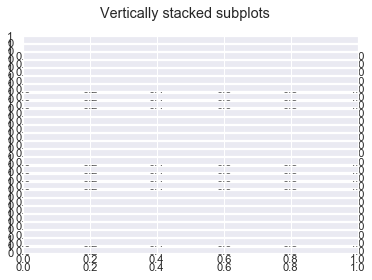

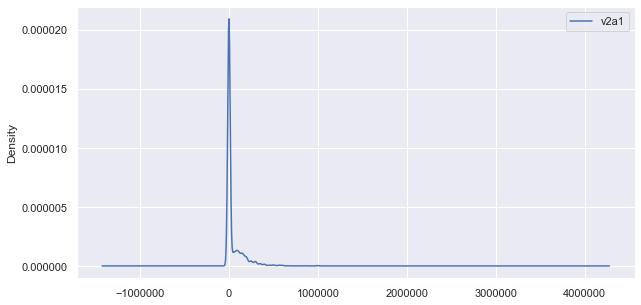

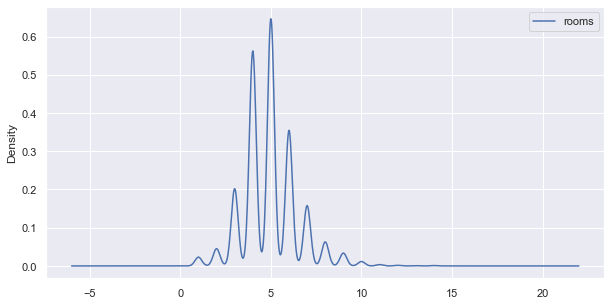

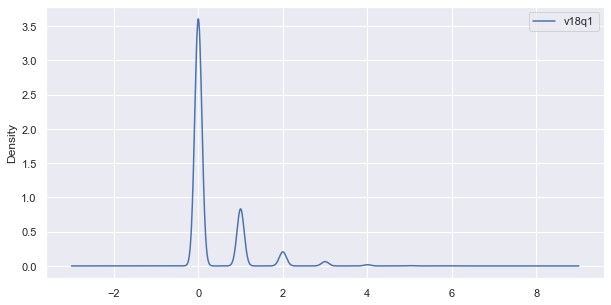

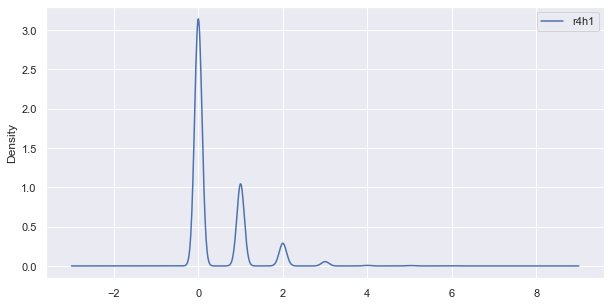

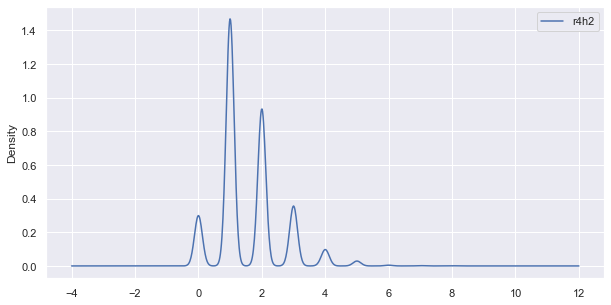

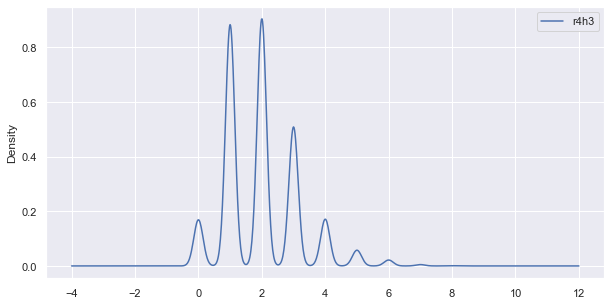

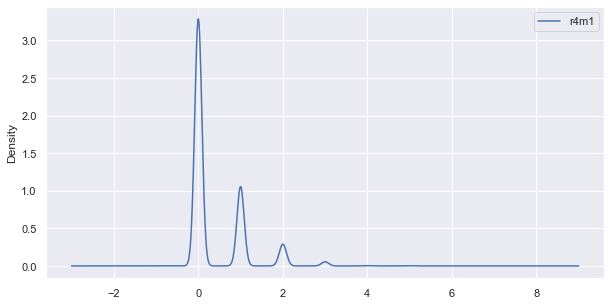

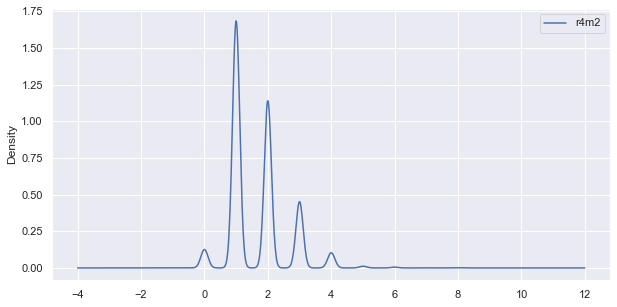

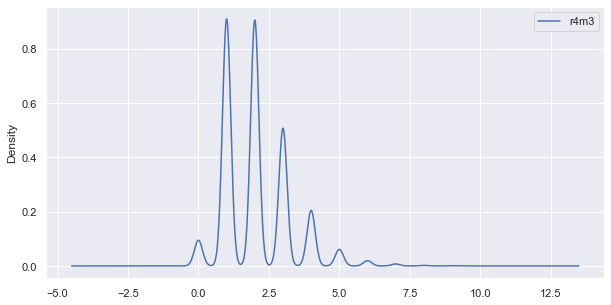

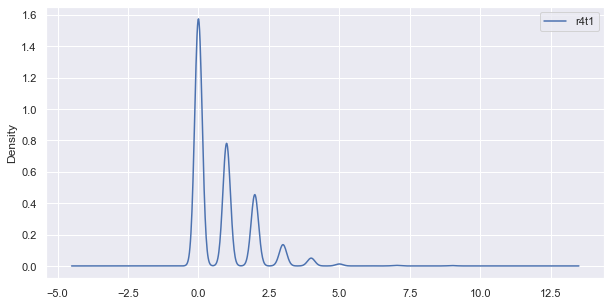

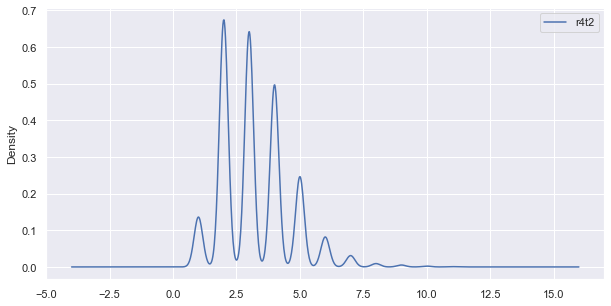

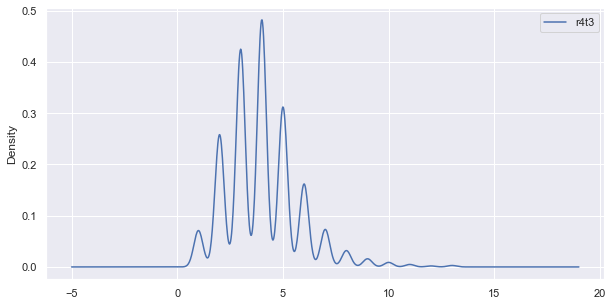

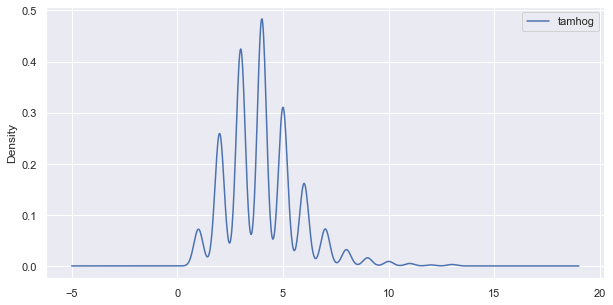

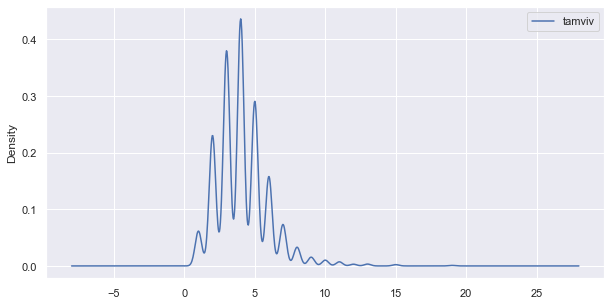

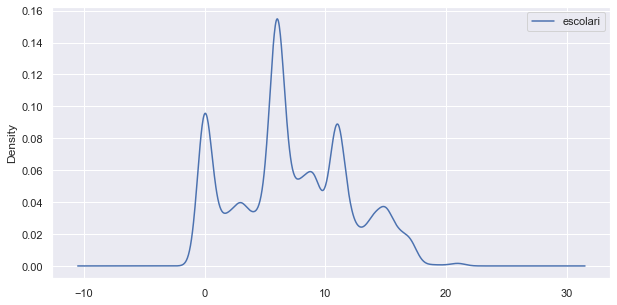

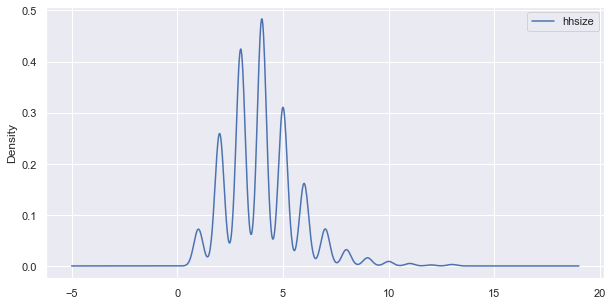

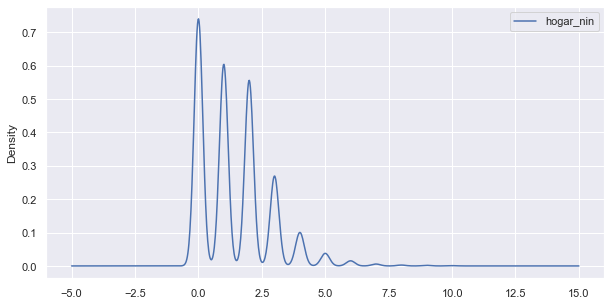

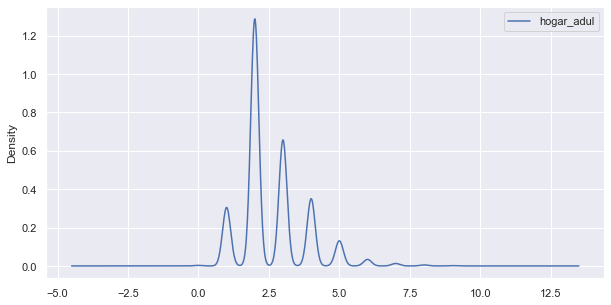

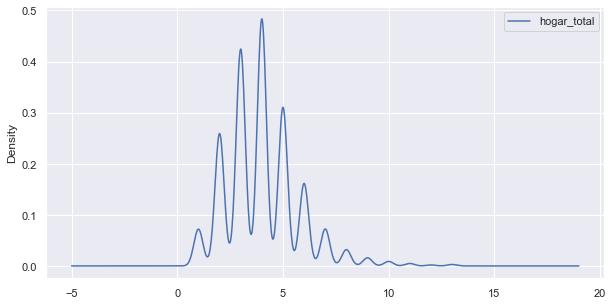

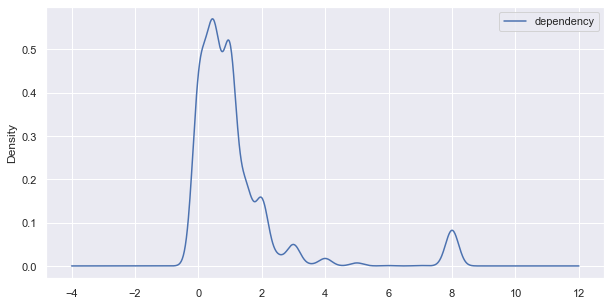

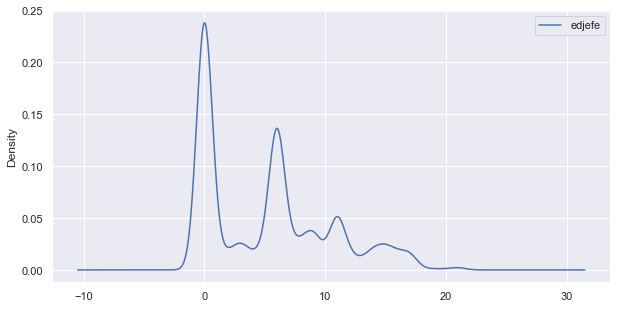

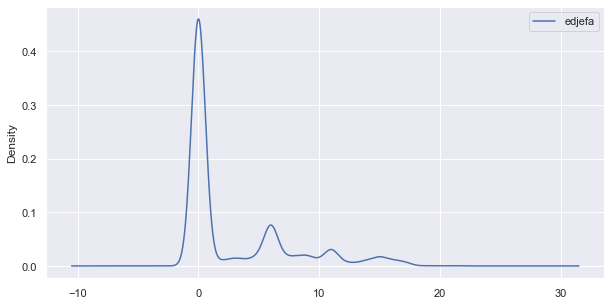

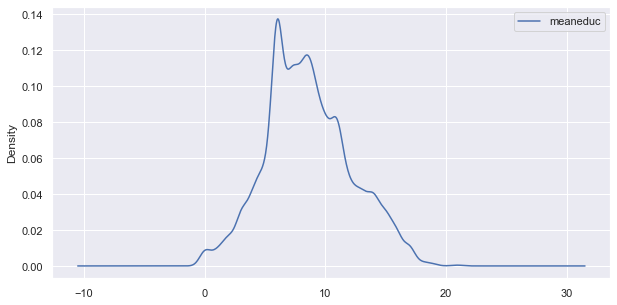

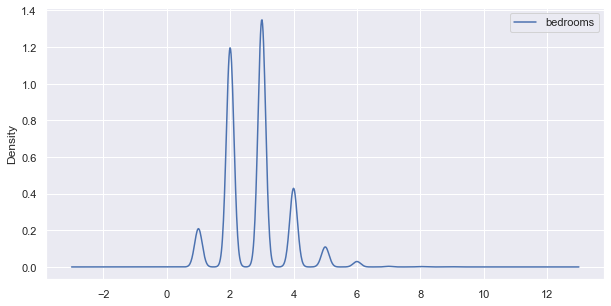

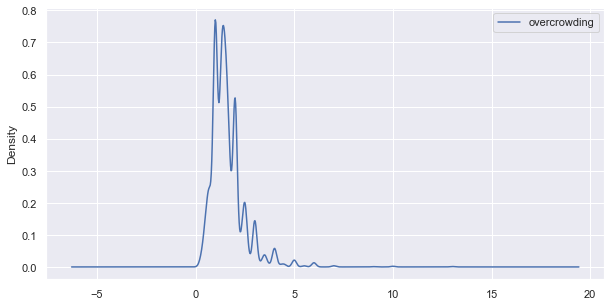

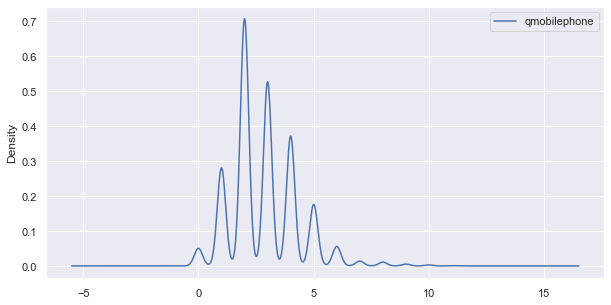

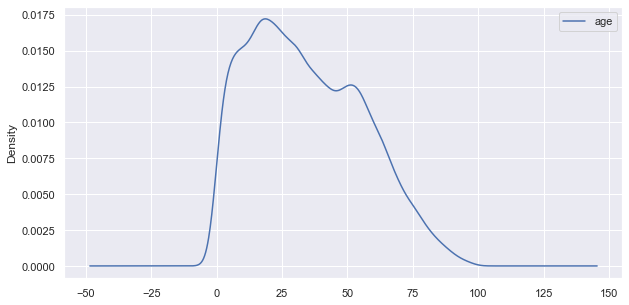

In [43]:
#View the distribution of numerical columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf = master.select_dtypes(include=numerics)
fig, axs = plt.subplots(newdf.columns.size)
fig.suptitle('Vertically stacked subplots')
i=0
for col in newdf.columns:
    axs[i] = master[[col]].plot.kde(figsize=[10,5])
    i+=1

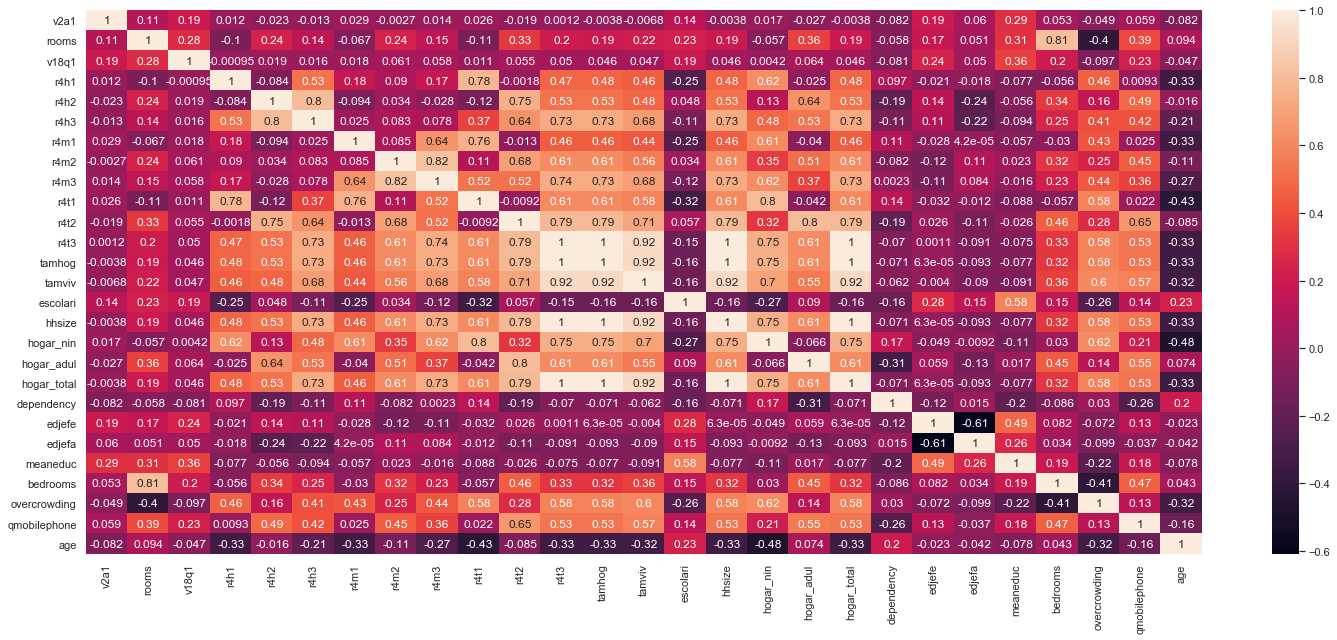

In [44]:
#plot heatmap for numerical columns to view the correlation
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(25,10))
sns.heatmap(newdf.corr(),annot=True,ax=ax)

# Inference and Feature Selection

From the heatmap, we get to know that r4t3, tamhog, hogartotal and hhsize are completely correlated, tamviv is also very highly correlated to r4t3, tamhog, hogartotal and hhsize, so lets drop these columns.

rooms and bedrooms are also correlated, hence we can remove bedrooms column as well

r4h1 and r4m1 are correlated to r4t1 ,r4h2 and r4m2 are correlated to r4t2,r4h3 and r4m3 are correlated to r4t3, hence we can remove r4h1,r4h2,r4h3,r4m1,r4m2 and r4m3 columns as well. r4t3 is sume of r4t1 and r4t2, hence we can remove r4t3 column as well

In [45]:
master.drop(['tamhog', 'hogar_total', 'hhsize','tamviv', 'bedrooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3','r4t3'],axis=1,inplace=True)

In [46]:
master.columns

Index(['v2a1', 'hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q', 'v18q1',
       'r4t1', 'r4t2',
       ...
       'lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6', 'area1',
       'area2', 'age', 'Target'],
      dtype='object', length=119)

In [47]:
master.shape

(33413, 119)

# Remove high variance columns

In [48]:
X = master.iloc[:,:118]
target = master.iloc[:,118:119]

In [49]:
X

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4t1,r4t2,...,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age
0,190000.0,0,3,0,1,1,0,0.0,0,1,...,1,1,0,0,0,0,0,1,0,43
1,135000.0,0,4,0,1,1,1,1.0,0,1,...,1,1,0,0,0,0,0,1,0,67
2,0.0,0,8,0,1,1,0,0.0,0,1,...,0,1,0,0,0,0,0,1,0,92
3,180000.0,0,5,0,1,1,1,1.0,1,3,...,3,1,0,0,0,0,0,1,0,17
4,180000.0,0,5,0,1,1,1,1.0,1,3,...,3,1,0,0,0,0,0,1,0,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23851,0.0,1,2,1,1,1,0,0.0,1,5,...,1,0,0,0,0,0,1,0,1,10
23852,0.0,0,3,0,1,1,0,0.0,0,4,...,2,0,0,0,0,0,1,0,1,54
23853,0.0,0,3,0,1,1,0,0.0,0,4,...,2,0,0,0,0,0,1,0,1,12
23854,0.0,0,3,0,1,1,0,0.0,0,4,...,2,0,0,0,0,0,1,0,1,12


In [50]:
target.shape

(33413, 1)

In [51]:
#Remove the Feature columns which have 80% or more samples biased towards a particular value 
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X = pd.DataFrame(sel.fit_transform(X))

In [52]:
X.shape

(33413, 43)

In [53]:
target.shape

(33413, 1)

In [54]:
X.reset_index(drop=True, inplace=True)
target.reset_index(drop=True, inplace=True)
df = pd.concat([X,target],axis=1)
df

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,Target
0,190000.0,3.0,0.0,0.0,0.0,1.0,10.0,1.0,1.0,0.0,...,0.0,1.000000,0.0,0.0,1.0,1.0,1.0,0.0,43.0,4.0
1,135000.0,4.0,1.0,1.0,0.0,1.0,12.0,0.0,0.0,0.0,...,0.0,1.000000,0.0,0.0,1.0,1.0,1.0,0.0,67.0,4.0
2,0.0,8.0,0.0,0.0,0.0,1.0,11.0,0.0,1.0,0.0,...,0.0,0.500000,1.0,0.0,0.0,1.0,1.0,0.0,92.0,4.0
3,180000.0,5.0,1.0,1.0,1.0,3.0,9.0,1.0,1.0,0.0,...,0.0,1.333333,0.0,0.0,3.0,1.0,1.0,0.0,17.0,4.0
4,180000.0,5.0,1.0,1.0,1.0,3.0,11.0,1.0,1.0,0.0,...,0.0,1.333333,0.0,0.0,3.0,1.0,1.0,0.0,37.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33408,0.0,2.0,0.0,0.0,1.0,5.0,3.0,0.0,0.0,1.0,...,0.0,6.000000,1.0,0.0,1.0,0.0,0.0,1.0,10.0,100.0
33409,0.0,3.0,0.0,0.0,0.0,4.0,6.0,0.0,0.0,1.0,...,1.0,2.000000,1.0,0.0,2.0,0.0,0.0,1.0,54.0,100.0
33410,0.0,3.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,1.0,...,0.0,2.000000,1.0,0.0,2.0,0.0,0.0,1.0,12.0,100.0
33411,0.0,3.0,0.0,0.0,0.0,4.0,5.0,0.0,0.0,1.0,...,0.0,2.000000,1.0,0.0,2.0,0.0,0.0,1.0,12.0,100.0


In [55]:
master1 = df[df.Target!=100]
master1.shape

(9557, 44)

In [56]:
master1.head(5)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,Target
0,190000.0,3.0,0.0,0.0,0.0,1.0,10.0,1.0,1.0,0.0,...,0.0,1.000000,0.0,0.0,1.0,1.0,1.0,0.0,43.0,4.0
1,135000.0,4.0,1.0,1.0,0.0,1.0,12.0,0.0,0.0,0.0,...,0.0,1.000000,0.0,0.0,1.0,1.0,1.0,0.0,67.0,4.0
2,0.0,8.0,0.0,0.0,0.0,1.0,11.0,0.0,1.0,0.0,...,0.0,0.500000,1.0,0.0,0.0,1.0,1.0,0.0,92.0,4.0
3,180000.0,5.0,1.0,1.0,1.0,3.0,9.0,1.0,1.0,0.0,...,0.0,1.333333,0.0,0.0,3.0,1.0,1.0,0.0,17.0,4.0
4,180000.0,5.0,1.0,1.0,1.0,3.0,11.0,1.0,1.0,0.0,...,0.0,1.333333,0.0,0.0,3.0,1.0,1.0,0.0,37.0,4.0


In [57]:
master1.Target.unique()

[4.0, 2.0, 3.0, 1.0]
Categories (4, float64): [4.0, 2.0, 3.0, 1.0]

In [58]:
X = master1.drop("Target",axis=1)
y = master1.Target

In [59]:
X.shape,y.shape

((9557, 43), (9557,))

In [60]:
master2 = df[df.Target==100]
master2.shape

(23856, 44)

In [61]:
master2.head(5)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,Target
9557,0.0,5.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,...,0.0,1.5,1.0,0.0,2.0,1.0,1.0,0.0,4.0,100.0
9558,0.0,5.0,0.0,0.0,1.0,2.0,16.0,1.0,1.0,0.0,...,0.0,1.5,1.0,0.0,2.0,1.0,1.0,0.0,41.0,100.0
9559,0.0,5.0,0.0,0.0,1.0,2.0,17.0,1.0,1.0,0.0,...,0.0,1.5,1.0,0.0,2.0,1.0,1.0,0.0,41.0,100.0
9560,0.0,14.0,1.0,1.0,0.0,1.0,16.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,2.0,1.0,1.0,0.0,59.0,100.0
9561,175000.0,4.0,1.0,1.0,0.0,1.0,11.0,1.0,1.0,0.0,...,0.0,0.5,0.0,0.0,1.0,1.0,1.0,0.0,18.0,100.0


In [62]:
Test_X = master2.drop('Target',axis=1)

In [63]:
Test_X.shape

(23856, 43)

# Check the accuracy using random forest with cross validation.

In [64]:
#Apply RandomForest Classifier and crossvalidate using stratifiedKFold Method

kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=45)
cv_score =[]
f1_scores = []
i=1
macro_roc_auc_ovo_scores = []
weighted_roc_auc_ovo_scores = []
macro_roc_auc_ovr_scores = []
weighted_roc_auc_ovr_scores = []
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y.loc[train_index],y.loc[test_index]
    #model
    clf = RandomForestClassifier(n_estimators=100,random_state=100,criterion='entropy',n_jobs=-1)
    clf.fit(xtr,ytr)
    ypred = clf.predict(xvl)
    score = metrics.accuracy_score(yvl,ypred)
    f1_score = metrics.f1_score(yvl,ypred,average='weighted')
    print('score: '+str(score)+' f1_score: '+str(f1_score))
    #print(clf.predict_proba(xvl)[:5])
    y_prob = clf.predict_proba(xvl)
    macro_roc_auc_ovo = roc_auc_score(yvl, y_prob, multi_class="ovo",average="macro")
    weighted_roc_auc_ovo = roc_auc_score(yvl, y_prob, multi_class="ovo",average="weighted")
    macro_roc_auc_ovr = roc_auc_score(yvl, y_prob, multi_class="ovr",average="macro")
    weighted_roc_auc_ovr = roc_auc_score(yvl, y_prob, multi_class="ovr",average="weighted")
    print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr))
    print("\n\n")
    macro_roc_auc_ovo_scores.append(macro_roc_auc_ovo)
    weighted_roc_auc_ovo_scores.append(weighted_roc_auc_ovo)
    macro_roc_auc_ovr_scores.append(macro_roc_auc_ovr)
    weighted_roc_auc_ovr_scores.append(weighted_roc_auc_ovr)
    cv_score.append(score)
    f1_scores.append(f1_score)
    print(metrics.classification_report(yvl, ypred, labels=[1.0,2.0,3.0,4.0]))
    print('Confusion matrix '+'\n',metrics.confusion_matrix(yvl,ypred))
    print('\n\n')
    i+=1
print('Cv',cv_score,'\nMean cv Score',np.mean(cv_score))
print('\n\n')
print('f1_score',f1_scores,'\nMean f1 weighted Score',np.mean(f1_scores))
print('\n\n')
print('macro_roc_auc_ovo_score '+str(np.mean(macro_roc_auc_ovo_scores))+' weighted_roc_auc_ovo_score '+str(np.mean(weighted_roc_auc_ovo_scores))+'\n')
print('macro_roc_auc_ovr_score '+str(np.mean(macro_roc_auc_ovr_scores))+' weighted_roc_auc_ovr_score '+str(np.mean(weighted_roc_auc_ovr_scores))+'\n')

1 of KFold 10
score: 0.9560669456066946 f1_score: 0.9555854233438758
One-vs-One ROC AUC scores:
0.995664 (macro),
0.995699 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.996212 (macro),
0.995100 (weighted by prevalence)



              precision    recall  f1-score   support

         1.0       0.98      0.84      0.91        77
         2.0       0.95      0.94      0.94       156
         3.0       0.97      0.91      0.94       122
         4.0       0.95      0.99      0.97       601

    accuracy                           0.96       956
   macro avg       0.97      0.92      0.94       956
weighted avg       0.96      0.96      0.96       956

Confusion matrix 
 [[ 65   1   0  11]
 [  1 146   0   9]
 [  0   0 111  11]
 [  0   6   3 592]]



2 of KFold 10
score: 0.9581589958158996 f1_score: 0.9574863786860621
One-vs-One ROC AUC scores:
0.992050 (macro),
0.993399 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.993916 (macro),
0.994484 (weighted by prevalence)



    

# Hyper Parameter Tuning

In [65]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 100,
 'verbose': 0,
 'warm_start': False}

In [66]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [67]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model

#split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 16.6min finished


{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': False}

# Use the best params and check the accuracy using random forest with cross validation.

In [68]:
#Cross Validate using StratifiedKFold Method.
kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=45)
cv_score =[]
f1_scores = []
macro_roc_auc_ovo_scores = []
weighted_roc_auc_ovo_scores = []
macro_roc_auc_ovr_scores = []
weighted_roc_auc_ovr_scores = []
i=1
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y.loc[train_index],y.loc[test_index]
    #model
    RF_clf = RandomForestClassifier(n_estimators=1400,max_depth=40,random_state=100,criterion='entropy',n_jobs=-1,bootstrap=False)
    RF_clf.fit(xtr,ytr)
    ypred = RF_clf.predict(xvl)
    score = metrics.accuracy_score(yvl,ypred)
    f1_score = metrics.f1_score(yvl,ypred,average='weighted')
    print('score: '+str(score)+' f1_score: '+str(f1_score)+"\n\n")
    y_prob = RF_clf.predict_proba(xvl)
    macro_roc_auc_ovo = roc_auc_score(yvl, y_prob, multi_class="ovo",average="macro")
    weighted_roc_auc_ovo = roc_auc_score(yvl, y_prob, multi_class="ovo",average="weighted")
    macro_roc_auc_ovr = roc_auc_score(yvl, y_prob, multi_class="ovr",average="macro")
    weighted_roc_auc_ovr = roc_auc_score(yvl, y_prob, multi_class="ovr",average="weighted")
    print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr))
    print("\n\n")
    macro_roc_auc_ovo_scores.append(macro_roc_auc_ovo)
    weighted_roc_auc_ovo_scores.append(weighted_roc_auc_ovo)
    macro_roc_auc_ovr_scores.append(macro_roc_auc_ovr)
    weighted_roc_auc_ovr_scores.append(weighted_roc_auc_ovr)
    cv_score.append(score)
    f1_scores.append(f1_score)
    print(metrics.classification_report(yvl, ypred, labels=[1.0,2.0,3.0,4.0]))
    print('Confusion matrix '+'\n',metrics.confusion_matrix(yvl,ypred))
    print('\n\n')
    i+=1
print('Cv',cv_score,'\nMean cv Score',np.mean(cv_score))
print('\n\n')
print('f1_score',f1_scores,'\nMean f1 weighted Score',np.mean(f1_scores))
print('\n\n')
print('macro_roc_auc_ovo_score '+str(np.mean(macro_roc_auc_ovo_scores))+' weighted_roc_auc_ovo_score '+str(np.mean(weighted_roc_auc_ovo_scores))+'\n')
print('macro_roc_auc_ovr_score '+str(np.mean(macro_roc_auc_ovr_scores))+' weighted_roc_auc_ovr_score '+str(np.mean(weighted_roc_auc_ovr_scores))+'\n')

1 of KFold 10
score: 0.9790794979079498 f1_score: 0.9789279542050964


One-vs-One ROC AUC scores:
0.997793 (macro),
0.997988 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.998110 (macro),
0.997985 (weighted by prevalence)



              precision    recall  f1-score   support

         1.0       0.96      0.91      0.93        77
         2.0       0.99      0.97      0.98       156
         3.0       0.98      0.96      0.97       122
         4.0       0.98      1.00      0.99       601

    accuracy                           0.98       956
   macro avg       0.98      0.96      0.97       956
weighted avg       0.98      0.98      0.98       956

Confusion matrix 
 [[ 70   1   1   5]
 [  2 151   0   3]
 [  0   0 117   5]
 [  1   1   1 598]]



2 of KFold 10
score: 0.9738493723849372 f1_score: 0.9736259712155484


One-vs-One ROC AUC scores:
0.995896 (macro),
0.996594 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.996771 (macro),
0.997344 (weighted by prevalence)





# Predict the Output variable for test data using random forest classifier.

In [69]:
#Predict Poverty level for Test Data

RF_clf.fit(X,y)
ypred = RF_clf.predict(Test_X)
ypred

array([4., 4., 4., ..., 4., 4., 4.])

In [70]:
np.unique(ypred)

array([1., 2., 3., 4.])

In [71]:
df = pd.DataFrame(X)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,190000.0,3.0,0.0,0.0,0.0,1.0,10.0,1.0,1.0,0.0,...,10.0,0.0,1.000000,0.0,0.0,1.0,1.0,1.0,0.0,43.0
1,135000.0,4.0,1.0,1.0,0.0,1.0,12.0,0.0,0.0,0.0,...,12.0,0.0,1.000000,0.0,0.0,1.0,1.0,1.0,0.0,67.0
2,0.0,8.0,0.0,0.0,0.0,1.0,11.0,0.0,1.0,0.0,...,11.0,0.0,0.500000,1.0,0.0,0.0,1.0,1.0,0.0,92.0
3,180000.0,5.0,1.0,1.0,1.0,3.0,9.0,1.0,1.0,0.0,...,11.0,0.0,1.333333,0.0,0.0,3.0,1.0,1.0,0.0,17.0
4,180000.0,5.0,1.0,1.0,1.0,3.0,11.0,1.0,1.0,0.0,...,11.0,0.0,1.333333,0.0,0.0,3.0,1.0,1.0,0.0,37.0


# Try KNN Algorithm

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:185: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


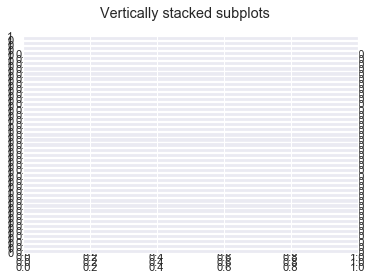

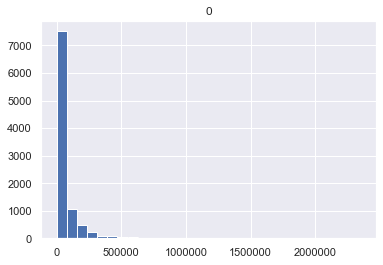

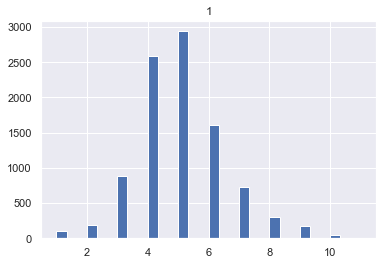

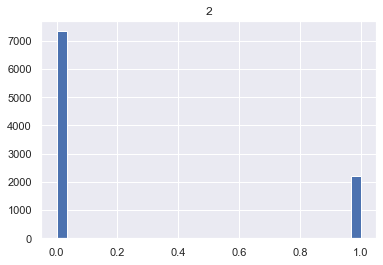

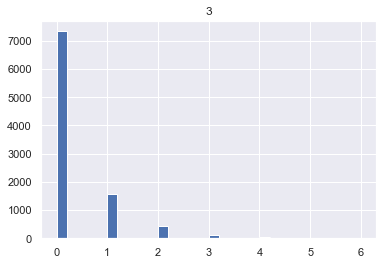

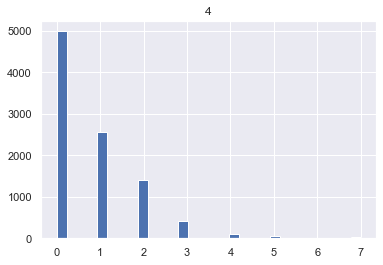

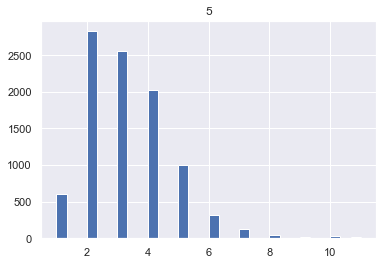

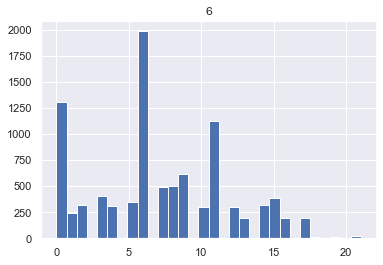

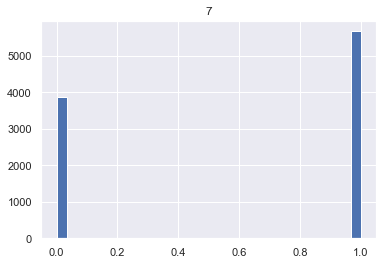

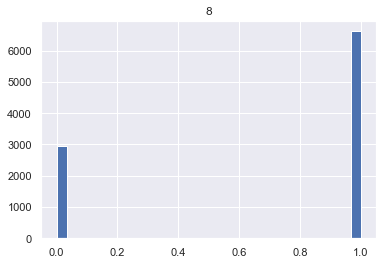

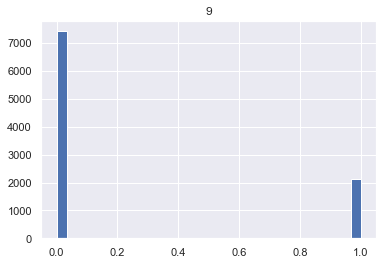

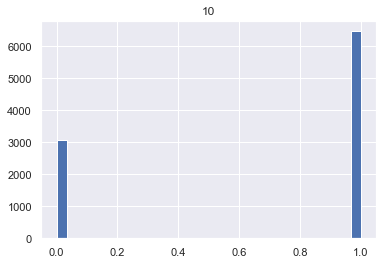

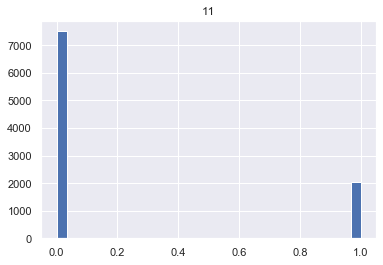

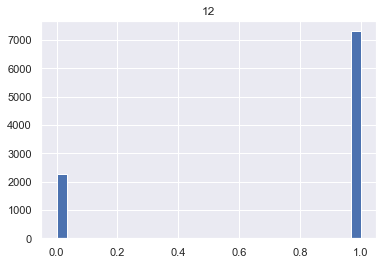

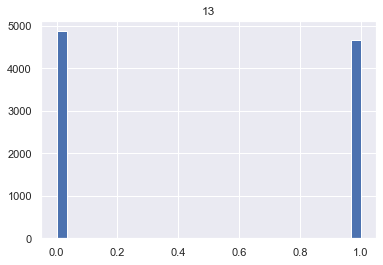

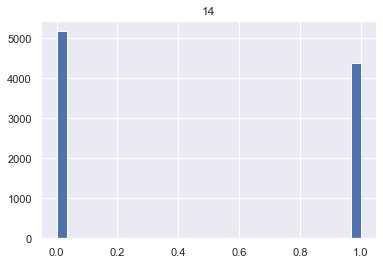

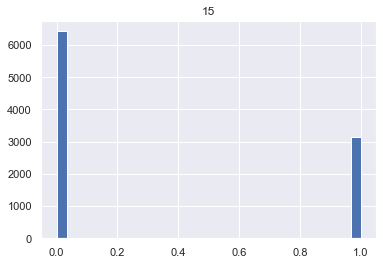

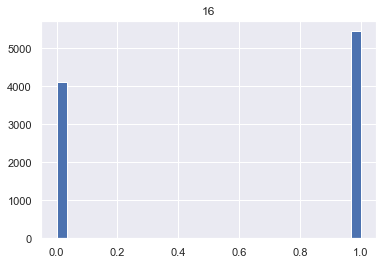

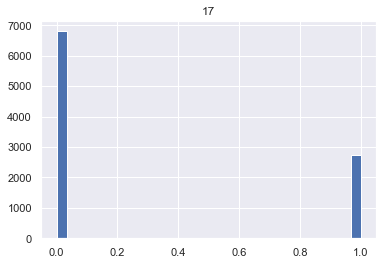

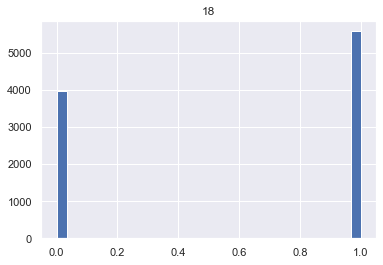

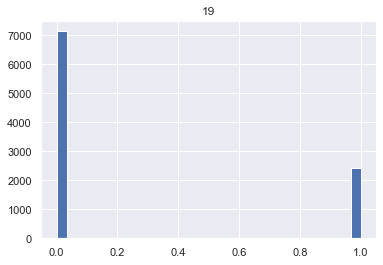

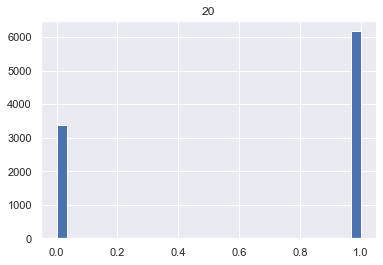

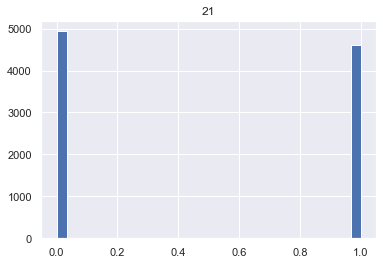

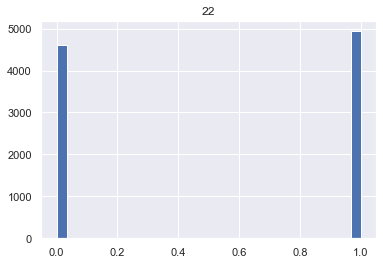

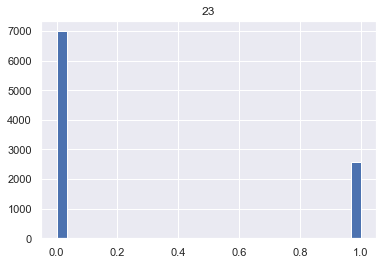

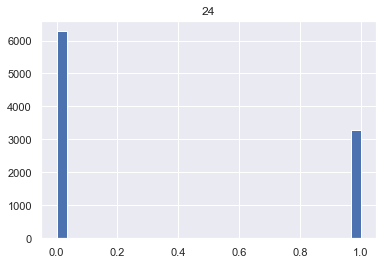

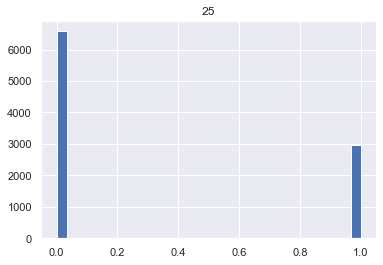

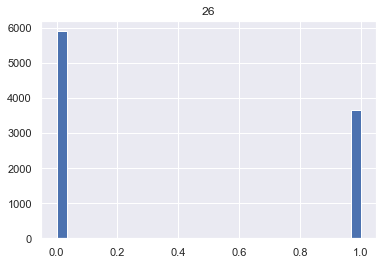

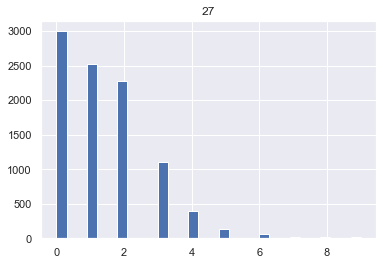

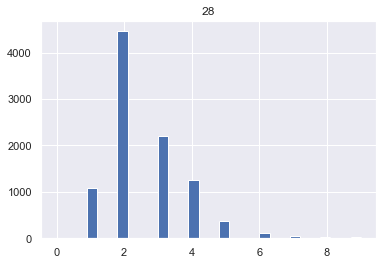

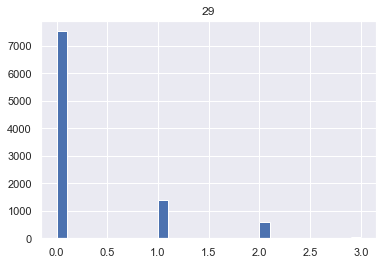

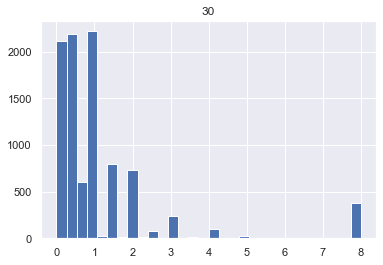

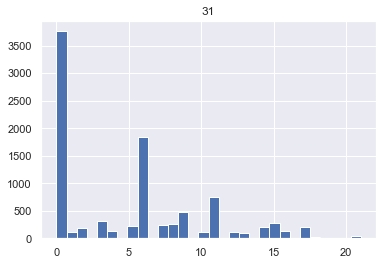

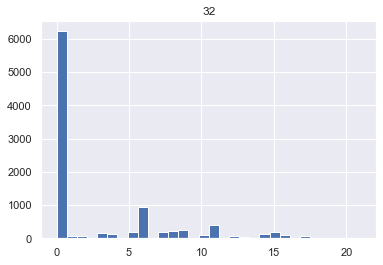

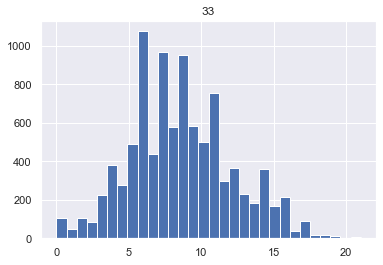

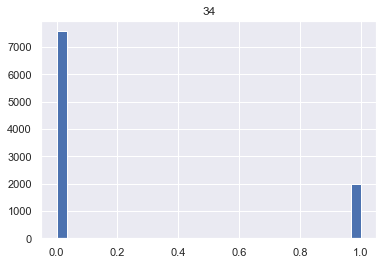

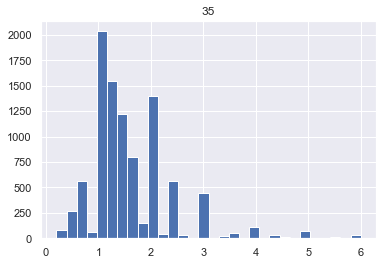

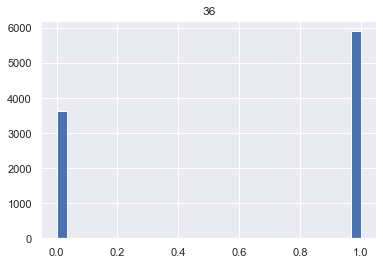

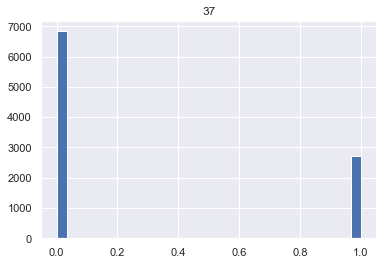

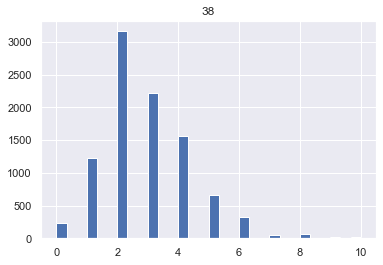

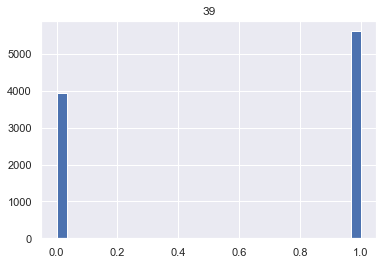

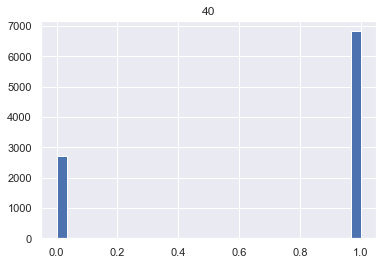

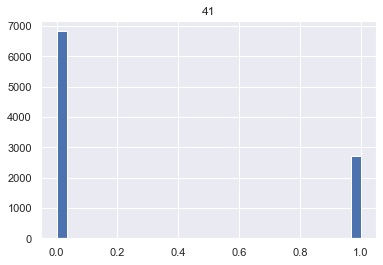

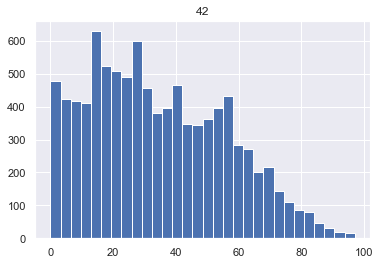

In [72]:
fig, axs = plt.subplots(df.columns.size)
fig.suptitle('Vertically stacked subplots')
i=0
for col in df.columns:
    axs[i] = df[[col]].hist(bins=30)
    i+=1

From the above plots, we see that the data is not normally distributed, hence we will use minmax scaling

In [73]:
scaler = MinMaxScaler()
X_Knn = scaler.fit_transform(X)

In [74]:
X_Knn = pd.DataFrame(X_Knn)
X_Knn

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0.080732,0.2,0.0,0.000000,0.000000,0.0,0.476190,1.0,1.0,0.0,...,0.476190,0.0,0.137931,0.0,0.0,0.1,1.0,1.0,0.0,0.443299
1,0.057362,0.3,1.0,0.166667,0.000000,0.0,0.571429,0.0,0.0,0.0,...,0.571429,0.0,0.137931,0.0,0.0,0.1,1.0,1.0,0.0,0.690722
2,0.000000,0.7,0.0,0.000000,0.000000,0.0,0.523810,0.0,1.0,0.0,...,0.523810,0.0,0.051724,1.0,0.0,0.0,1.0,1.0,0.0,0.948454
3,0.076483,0.4,1.0,0.166667,0.142857,0.2,0.428571,1.0,1.0,0.0,...,0.523810,0.0,0.195402,0.0,0.0,0.3,1.0,1.0,0.0,0.175258
4,0.076483,0.4,1.0,0.166667,0.142857,0.2,0.523810,1.0,1.0,0.0,...,0.523810,0.0,0.195402,0.0,0.0,0.3,1.0,1.0,0.0,0.381443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9552,0.033992,0.5,0.0,0.000000,0.142857,0.3,0.428571,1.0,0.0,1.0,...,0.392857,0.0,0.181034,0.0,1.0,0.3,0.0,0.0,1.0,0.474227
9553,0.033992,0.5,0.0,0.000000,0.142857,0.3,0.000000,1.0,0.0,1.0,...,0.392857,0.0,0.181034,0.0,1.0,0.3,0.0,0.0,1.0,0.020619
9554,0.033992,0.5,0.0,0.000000,0.142857,0.3,0.238095,1.0,0.0,1.0,...,0.392857,0.0,0.181034,0.0,1.0,0.3,0.0,0.0,1.0,0.515464
9555,0.033992,0.5,0.0,0.000000,0.142857,0.3,0.523810,1.0,0.0,1.0,...,0.392857,0.0,0.181034,0.0,1.0,0.3,0.0,0.0,1.0,0.268041


In [75]:
Test_X_Knn = scaler.transform(Test_X)
Test_X_Knn = pd.DataFrame(Test_X)
Test_X_Knn

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
9557,0.0,5.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,...,16.5,0.0,1.5,1.0,0.0,2.0,1.0,1.0,0.0,4.0
9558,0.0,5.0,0.0,0.0,1.0,2.0,16.0,1.0,1.0,0.0,...,16.5,0.0,1.5,1.0,0.0,2.0,1.0,1.0,0.0,41.0
9559,0.0,5.0,0.0,0.0,1.0,2.0,17.0,1.0,1.0,0.0,...,16.5,0.0,1.5,1.0,0.0,2.0,1.0,1.0,0.0,41.0
9560,0.0,14.0,1.0,1.0,0.0,1.0,16.0,1.0,1.0,0.0,...,16.0,0.0,1.0,1.0,0.0,2.0,1.0,1.0,0.0,59.0
9561,175000.0,4.0,1.0,1.0,0.0,1.0,11.0,1.0,1.0,0.0,...,11.0,0.0,0.5,0.0,0.0,1.0,1.0,1.0,0.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33408,0.0,2.0,0.0,0.0,1.0,5.0,3.0,0.0,0.0,1.0,...,4.6,0.0,6.0,1.0,0.0,1.0,0.0,0.0,1.0,10.0
33409,0.0,3.0,0.0,0.0,0.0,4.0,6.0,0.0,0.0,1.0,...,6.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,1.0,54.0
33410,0.0,3.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,1.0,...,6.0,0.0,2.0,1.0,0.0,2.0,0.0,0.0,1.0,12.0
33411,0.0,3.0,0.0,0.0,0.0,4.0,5.0,0.0,0.0,1.0,...,6.0,0.0,2.0,1.0,0.0,2.0,0.0,0.0,1.0,12.0


In [76]:
#Cross Validate using StratifiedKFold Method.
kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=45)
cv_score =[]
f1_scores = []
macro_roc_auc_ovo_scores = []
weighted_roc_auc_ovo_scores = []
macro_roc_auc_ovr_scores = []
weighted_roc_auc_ovr_scores = []
i=1
for train_index,test_index in kf.split(X_Knn,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X_Knn.loc[train_index],X_Knn.loc[test_index]
    ytr,yvl = y.loc[train_index],y.loc[test_index]
    #model
    KNN_clf = KNeighborsClassifier(n_neighbors=3)
    KNN_clf.fit(xtr, ytr)
    ypred = KNN_clf.predict(xvl)
    score = metrics.accuracy_score(yvl,ypred)
    f1_score = metrics.f1_score(yvl,ypred,average='weighted')
    print('score: '+str(score)+' f1_score: '+str(f1_score)+"\n\n")
    y_prob = KNN_clf.predict_proba(xvl)
    macro_roc_auc_ovo = roc_auc_score(yvl, y_prob, multi_class="ovo",average="macro")
    weighted_roc_auc_ovo = roc_auc_score(yvl, y_prob, multi_class="ovo",average="weighted")
    macro_roc_auc_ovr = roc_auc_score(yvl, y_prob, multi_class="ovr",average="macro")
    weighted_roc_auc_ovr = roc_auc_score(yvl, y_prob, multi_class="ovr",average="weighted")
    print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr))
    print("\n\n")
    macro_roc_auc_ovo_scores.append(macro_roc_auc_ovo)
    weighted_roc_auc_ovo_scores.append(weighted_roc_auc_ovo)
    macro_roc_auc_ovr_scores.append(macro_roc_auc_ovr)
    weighted_roc_auc_ovr_scores.append(weighted_roc_auc_ovr)
    cv_score.append(score)
    f1_scores.append(f1_score)
    print(metrics.classification_report(yvl, ypred, labels=[1.0,2.0,3.0,4.0]))
    print('Confusion matrix '+'\n',metrics.confusion_matrix(yvl,ypred))
    print('\n\n')
    i+=1
print('Cv',cv_score,'\nMean cv Score',np.mean(cv_score))
print('\n\n')
print('f1_score',f1_scores,'\nMean f1 weighted Score',np.mean(f1_scores))
print('\n\n')
print('macro_roc_auc_ovo_score '+str(np.mean(macro_roc_auc_ovo_scores))+' weighted_roc_auc_ovo_score '+str(np.mean(weighted_roc_auc_ovo_scores))+'\n')
print('macro_roc_auc_ovr_score '+str(np.mean(macro_roc_auc_ovr_scores))+' weighted_roc_auc_ovr_score '+str(np.mean(weighted_roc_auc_ovr_scores))+'\n')

1 of KFold 10
score: 0.7092050209205021 f1_score: 0.6976285432010515


One-vs-One ROC AUC scores:
0.765634 (macro),
0.782442 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.779693 (macro),
0.796958 (weighted by prevalence)



              precision    recall  f1-score   support

         1.0       0.44      0.52      0.48        77
         2.0       0.54      0.56      0.55       156
         3.0       0.51      0.26      0.35       122
         4.0       0.81      0.86      0.83       601

    accuracy                           0.71       956
   macro avg       0.58      0.55      0.55       956
weighted avg       0.70      0.71      0.70       956

Confusion matrix 
 [[ 40  10   5  22]
 [ 16  88   8  44]
 [ 11  23  32  56]
 [ 24  41  18 518]]



2 of KFold 10
score: 0.7123430962343096 f1_score: 0.707744562370991


One-vs-One ROC AUC scores:
0.798565 (macro),
0.813527 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.810279 (macro),
0.822392 (weighted by prevalence)



 

# Lets try to tune the HyperParameters, to increase the accuracy

In [77]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 100,
 'verbose': 0,
 'warm_start': False}

In [78]:
n_neighbors = [3,5,7,9]
weights = ['uniform', 'distance']
p = [1,2,3]
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
leaf_size = [30, 40, 50, 60, 70]
random_grid = {'n_neighbors': n_neighbors,
               'weights': weights,
               'p': p,
               'algorithm': algorithm,
               'leaf_size': leaf_size}
print(random_grid)

{'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance'], 'p': [1, 2, 3], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size': [30, 40, 50, 60, 70]}


In [79]:
KNN_clf = KNeighborsClassifier()
clf_random = RandomizedSearchCV(estimator = KNN_clf, param_distributions = random_grid, n_iter = 120, cv = 4, verbose=2, random_state=42, n_jobs = -1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

clf_random.fit(X_train, y_train)
clf_random.best_params_

Fitting 4 folds for each of 120 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  3.1min finished


{'weights': 'distance',
 'p': 1,
 'n_neighbors': 3,
 'leaf_size': 40,
 'algorithm': 'auto'}

In [82]:
#Cross Validate using StratifiedKFold Method.
kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=45)
cv_score =[]
f1_scores = []
macro_roc_auc_ovo_scores = []
weighted_roc_auc_ovo_scores = []
macro_roc_auc_ovr_scores = []
weighted_roc_auc_ovr_scores = []
i=1
for train_index,test_index in kf.split(X_Knn,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X_Knn.loc[train_index],X_Knn.loc[test_index]
    ytr,yvl = y.loc[train_index],y.loc[test_index]
    #model
    KNN_clf = KNeighborsClassifier(n_neighbors=3,weights='distance',p=1,leaf_size=40,algorithm='auto')
    KNN_clf.fit(xtr, ytr)
    ypred = KNN_clf.predict(xvl)
    score = metrics.accuracy_score(yvl,ypred)
    f1_score = metrics.f1_score(yvl,ypred,average='weighted')
    print('score: '+str(score)+' f1_score: '+str(f1_score)+"\n\n")
    y_prob = KNN_clf.predict_proba(xvl)
    macro_roc_auc_ovo = roc_auc_score(yvl, y_prob, multi_class="ovo",average="macro")
    weighted_roc_auc_ovo = roc_auc_score(yvl, y_prob, multi_class="ovo",average="weighted")
    macro_roc_auc_ovr = roc_auc_score(yvl, y_prob, multi_class="ovr",average="macro")
    weighted_roc_auc_ovr = roc_auc_score(yvl, y_prob, multi_class="ovr",average="weighted")
    print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr))
    print("\n\n")
    macro_roc_auc_ovo_scores.append(macro_roc_auc_ovo)
    weighted_roc_auc_ovo_scores.append(weighted_roc_auc_ovo)
    macro_roc_auc_ovr_scores.append(macro_roc_auc_ovr)
    weighted_roc_auc_ovr_scores.append(weighted_roc_auc_ovr)
    cv_score.append(score)
    f1_scores.append(f1_score)
    print(metrics.classification_report(yvl, ypred, labels=[1.0,2.0,3.0,4.0]))
    print('Confusion matrix '+'\n',metrics.confusion_matrix(yvl,ypred))
    print('\n\n')
    i+=1
print('Cv',cv_score,'\nMean cv Score',np.mean(cv_score))
print('\n\n')
print('f1_score',f1_scores,'\nMean f1 weighted Score',np.mean(f1_scores))
print('\n\n')
print('macro_roc_auc_ovo_score '+str(np.mean(macro_roc_auc_ovo_scores))+' weighted_roc_auc_ovo_score '+str(np.mean(weighted_roc_auc_ovo_scores))+'\n')
print('macro_roc_auc_ovr_score '+str(np.mean(macro_roc_auc_ovr_scores))+' weighted_roc_auc_ovr_score '+str(np.mean(weighted_roc_auc_ovr_scores))+'\n')

1 of KFold 10
score: 0.7949790794979079 f1_score: 0.7874315959042774


One-vs-One ROC AUC scores:
0.850566 (macro),
0.863382 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.859271 (macro),
0.879247 (weighted by prevalence)



              precision    recall  f1-score   support

         1.0       0.66      0.56      0.61        77
         2.0       0.74      0.67      0.70       156
         3.0       0.65      0.50      0.56       122
         4.0       0.84      0.92      0.88       601

    accuracy                           0.79       956
   macro avg       0.72      0.66      0.69       956
weighted avg       0.79      0.79      0.79       956

Confusion matrix 
 [[ 43   8   5  21]
 [  6 105  10  35]
 [  3  10  61  48]
 [ 13  19  18 551]]



2 of KFold 10
score: 0.7960251046025104 f1_score: 0.7929277015660179


One-vs-One ROC AUC scores:
0.884192 (macro),
0.892718 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.889888 (macro),
0.899847 (weighted by prevalence)





# Predict the Output variable for test data using KNN classifier.

In [83]:
clf.fit(X_Knn,y)
ypred = clf.predict(Test_X_Knn)
ypred

array([4., 4., 4., ..., 4., 4., 4.])

# Conclusion

We applied the RandomForest and KNN Classifier to predict the Income Qualification of the member.
We see that the Random Forest Classifier performed very well compared to the KNN Classifier. In thr former, we got almost 98% Accuracy/f1 score after tuning the hyperparameters, but with KNN , we could achieve only upto 80% Accuracy/f1 score. Hence we select the RandomForest classifier.

In [84]:
#Pickle and save the model
saved_model = pickle.dumps(RF_clf)